# Mean Force Integration

The aim of this notebook is to provide examples, as how to run metadynamics simulations, analyse them with MFI and use other useful features.
The layout of this notebook is as follows:

A: Simulations on Alanine Dipeptide

    (1) - Analysing a metadynamics simulations with MFI
    (2) - Running a new simulation and patching (1) and (2) together
    (3) - Running a new simulation with a harmonic potential and patching (1) and (3) together 

B: Simulations on Bjola Potential

    (1) - Running a metadynamics simulation and analyse with MFI
    (2) - Running 10 short simulations (each 1/10 the length of (1), and patch togehter with MFI)
    ###(3) - Running a new simulation with a harmonic potential and patching (1) and (3) together ### Maybe repetitive###

C: Simulations on Invernizzi Potential

    (1) - Running a metadynamics simulation and analyse with MFI
    (2) - Running multiple short simulations, patch togehter with MFI, and determine bootstrap error


In [1]:
import os
import numpy as np
from pyMFI import MFI
from pyMFI import run_plumed
import pickle
import matplotlib.pyplot as plt

results_path = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/results_plot"
path_data = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/AlanineDipeptide_pyMFI"

path = os.getcwd()
print("The path to this notebook is:", path)

The path to this notebook is: /home/antoniu/Desktop/MFI_git/MFI_master/MFI


## A: Alanine Dipeptide | 2D periodic CV space example.

#### (1) - Analysing an existing metadynamics simulations with MFI.

A metadynaics simulation was already conducted. The resulting trajectory as CV's coordinates are saved in the file "positon0" and the corresponding HILLS file is saved as "HILLS0".

Preparing new input files ...
Running Alanine Dipeptide simulation
... Simulation finished.

Total no. of Gaussians analysed: 3000
|600/3000|==> Average Mean Force Error: 9741.37397362706
|1200/3000|==> Average Mean Force Error: 1736.483976542009
|1800/3000|==> Average Mean Force Error: 1169.390887795369
|2400/3000|==> Average Mean Force Error: 730.2435342997861
|3000/3000|==> Average Mean Force Error: 612.5653692225694


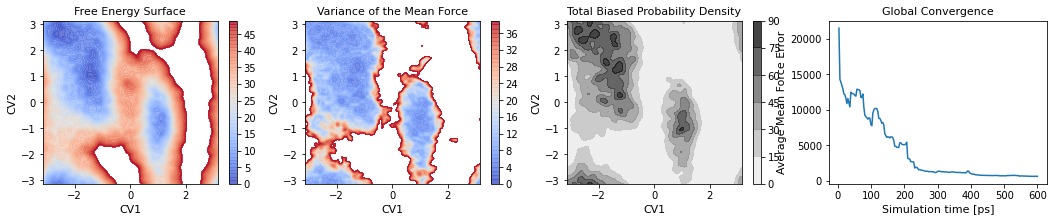

In [88]:
os.chdir("/home/antoniu/Desktop/MFI_git/MFI_master/MFI")
os.chdir("AlanineDipeptide_pyMFI")

#simulations steps for new simulation.
simulation_steps = 300000

#prepare new input files
run_plumed.find_alanine_dipeptide_input(initial_position_x=0.0, initial_position_y=0.0, file_extension="_1sim")

#Run Alanine dipeptide simulation
run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=3, biasfactor=20, gaus_pace=100, file_extension="_1sim")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_1sim")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_1sim")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, ofe_history_time, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, log_pace = 5, error_pace = 200, WellTempered=1, nhills=-1, periodic=1)

#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe, ofe_history, ofe_history_time)

In [89]:
#rename old results
Froce_terms_old = [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]
ofe_history_old = [ofe_history, ofe_history_time]

#### (2) - Running a new simulation and patching (1) and (2) together

Requires that simulation (1) has already been analysed and the force terms and error progression to be saved in the Froce_terms_old and ofe_history_old list.

Preparing new input files ...
Running Alanine Dipeptide simulation
... Simulation finished.

Total no. of Gaussians analysed: 3000
|300/3000|==> Average Mean Force Error: 607.7680733600909
|600/3000|==> Average Mean Force Error: 607.3090069146406
|900/3000|==> Average Mean Force Error: 604.1315683259965
|1200/3000|==> Average Mean Force Error: 597.9191736419488
|1500/3000|==> Average Mean Force Error: 598.1814894981006
|1800/3000|==> Average Mean Force Error: 546.6766921785304
|2100/3000|==> Average Mean Force Error: 549.3739623957305
|2400/3000|==> Average Mean Force Error: 594.8379428208181
|2700/3000|==> Average Mean Force Error: 607.306650181036
|3000/3000|==> Average Mean Force Error: 586.1043567176583


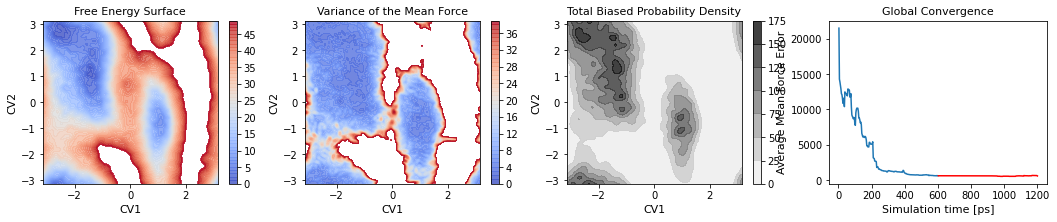

In [92]:
#simulations steps for new simulation. Same as before.
simulation_steps = 300000

#prepare new input files
run_plumed.find_alanine_dipeptide_input(initial_position_x=0.0, initial_position_y=0.0, file_extension="_2sim")

#Run Alanine dipeptide simulation
run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=3, biasfactor=20, gaus_pace=100, file_extension="_2sim")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name=path_data + "/HILLS" + "_2sim")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name=path_data + "/position" + "_2sim")

# Compute the time-independent mean force
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, periodic=1, base_terms = Froce_terms_old)

[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, ofe_history_time, Ftot_den2, ofv_x, ofv_y] = results

#Patch results
patch = MFI.patch_2D([Froce_terms_old, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]])
ofe_history_time = [element+ofe_history_old[1][-1] for element in ofe_history_time]


#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(patch[2], patch[3])

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, patch[0], ofe, ofe_history_old[0], ofe_history_old[1])
plt.plot(ofe_history_time, ofe_history, c="r")
plt.show()

# # Save Force terms
# Ftot_master = [X, Y, Ftot_den, FES, patch[0], ofe, ofe_history_old[0], ofe_history_old[1], ofe_history_time, ofe_history]
# with open(results_path + "/alanine_dipeptide_patch2.pkl","wb") as fw:
#     pickle.dump(Ftot_master, fw)

#### (3) - Running a new simulation with a harmonic potential and patching (1) and (3) together

Requires that simulation (1) has already been analysed and the force terms and error progression to be saved in the Froce_terms_old and ofe_history_old list.



Preparing new input files ...
Running Alanine Dipeptide simulation
... Simulation finished.

Total no. of Gaussians analysed: 1500
|150/1500|==> Average Mean Force Error: 579.2480077968378
|300/1500|==> Average Mean Force Error: 582.4773830582152
|450/1500|==> Average Mean Force Error: 571.7365556858324
|600/1500|==> Average Mean Force Error: 556.6196169014245
|750/1500|==> Average Mean Force Error: 555.8196096756293
|900/1500|==> Average Mean Force Error: 530.8177368739329
|1050/1500|==> Average Mean Force Error: 521.8576505134183
|1200/1500|==> Average Mean Force Error: 519.697425649659
|1350/1500|==> Average Mean Force Error: 523.2070062468442
|1500/1500|==> Average Mean Force Error: 522.0516999475104


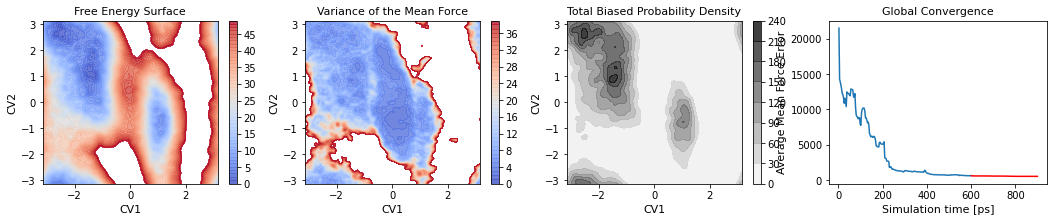

In [90]:
path_data = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/AlanineDipeptide_pyMFI"
os.chdir(path_data)

simulation_steps = 150000

#prepare new input files
run_plumed.find_alanine_dipeptide_input(initial_position_x=0.0, initial_position_y=0.0, file_extension="_static")

# #Run Alanine dipeptide simulation
run_plumed.run_alanine_dipeptide(simulation_steps, temperature=2.49, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=1, biasfactor=20, gaus_pace=100, 
                                 hp_center_x=0.0, hp_center_y=0.0, hp_kappa_x=150, hp_kappa_y=0, file_extension="_static")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name=path_data + "/HILLS" + "_static")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name=path_data + "/position" + "_static")

# Compute the time-independent mean force
results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 2.49, periodic=1, base_terms = Froce_terms_old, log_pace = 10, error_pace = 200, 
                    hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=150, hp_kappa_y=0)
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, ofe_history_time, Ftot_den2, ofv_x, ofv_y] = results

#Patch results
[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y] = MFI.patch_2D([Froce_terms_old, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]])
ofe_history_time = [element+ofe_history_old[1][-1] for element in ofe_history_time]

#integration with the FFT method
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y)

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, patch[0], ofe, ofe_history_old[0], ofe_history_old[1])
plt.plot(ofe_history_time, ofe_history, c="r")
plt.show()

(-3.141592653589793, 3.141592653589793)

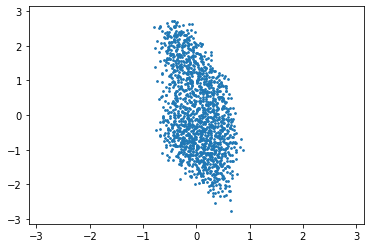

In [91]:
#Plot CV coordinates of simulation with harmonic potential

plt.scatter(HILLS[:,1], HILLS[:,2], s=3)
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)


## B: Bjola potential | 2D non-periodic example

Analytical function: $z(x,y) = 7*x^4-23*x^2+7*y^4-23*y^2$

#### (1) - Running a metadynamics simulation and analyse with MFI

Total no. of Gaussians analysed: 2500
|500/2500|==> Average Mean Force Error: 224.91564617956462
ofe_window 2331.491386281515
|1000/2500|==> Average Mean Force Error: 110.34032340963543
ofe_window 1459.44310276752
|1500/2500|==> Average Mean Force Error: 59.01927590524197
ofe_window 781.7985605041783
|2000/2500|==> Average Mean Force Error: 26.16570428260134
ofe_window 303.1942122344535
|2500/2500|==> Average Mean Force Error: 12.82396879071552
ofe_window 114.79640732216394


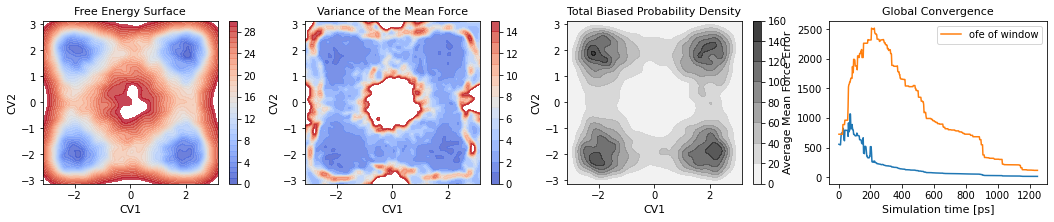

In [58]:
path_bjola = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/Antoniu_2D_potential"
os.chdir(path_bjola)

# #Run simulation
# run_plumed.run_langevin2D(250000, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=2, biasfactor=20, gaus_pace=100, file_extension="_1M")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS_1M")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position_1M")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, ofe_history_window, ofe_history_time, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)), log_pace = 5, error_pace = 500, nhills=-1, window_corners=[-0.5, 0.5, -0.5, 0.5])

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)))

#Simpler integration test
[X, Y, FES2] = MFI.intg_2D(Ftot_x, Ftot_y) 

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe, ofe_history, ofe_history_time, FES_lim=31, ofe_map_lim=16)
plt.plot(ofe_history_time, ofe_history_window, label="ofe of window")
plt.legend()
plt.show()


In [59]:
#rename old results
Froce_terms_old = [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]
ofe_history_old = ofe_history
ofe_history_window_old = ofe_history_window
ofe_history_time_old = ofe_history_time

#### (2) - Running 10 short simulations (each 1/10 the length of (1), and patch togehter with MFI)

Simulation: 0
Total no. of Gaussians analysed: 1000
|1000/1000|==> Average Mean Force Error: 53.183508247825
Simulation: 1
Total no. of Gaussians analysed: 1000
|1000/1000|==> Average Mean Force Error: 24.305465269319246
Simulation: 2
Total no. of Gaussians analysed: 1000
|1000/1000|==> Average Mean Force Error: 16.41453263766433
Simulation: 3
Total no. of Gaussians analysed: 1000
|1000/1000|==> Average Mean Force Error: 16.822348166999365
Simulation: 4
Total no. of Gaussians analysed: 1000
|1000/1000|==> Average Mean Force Error: 28.74544031828488
Simulation: 5
Total no. of Gaussians analysed: 1000
|1000/1000|==> Average Mean Force Error: 15.571457444640162
Simulation: 6
Total no. of Gaussians analysed: 1000
|1000/1000|==> Average Mean Force Error: 13.756915557515168
Simulation: 7
Total no. of Gaussians analysed: 1000
|1000/1000|==> Average Mean Force Error: 40.368835537522614
Simulation: 8
Total no. of Gaussians analysed: 1000
|1000/1000|==> Average Mean Force Error: 39.7491317162781

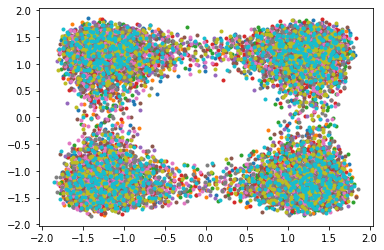

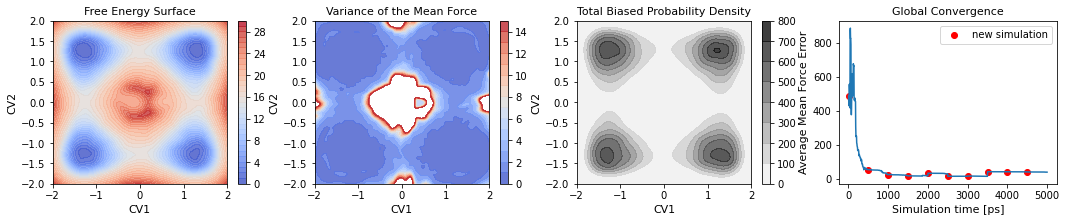

In [56]:
path_bjola = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/Antoniu_2D_potential"
os.chdir(path_bjola)


simulation_steps = 100000
master = []
master_patch = [[np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200))]]
ofe_history_patch = [0]
ofe_history_patch_time = [0]


for simulation in np.arange(0,10): 

    print('Simulation: '+str(simulation))
    file_extension="_s" + str(int(simulation))
    
    # ipos=1.3*(2 * np.random.rand(2) - 1)
    # #RUN short sim from random location
    # run_plumed.run_langevin2D(simulation_steps, initial_position_x=ipos[0], initial_position_y=ipos[1], gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=2, biasfactor=20, gaus_pace=100, file_extension=file_extension)

    #Read the HILLS and position file file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLS" + file_extension)
    [position_x, position_y] = MFI.load_position_2D(position_name="position" + file_extension)
    plt.plot(HILLS[:,1],HILLS[:,2],'.')

    #COMPUTE Mean force and weight of the simulation
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, ofe_history_time, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)), log_pace = 1, error_pace = 100, base_terms = master_patch[-1])
    
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save ofe history
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in ofe_history_time]
    ofe_history_patch_time += ofe_history_time_adj
    
#find "standard devaition of mean force" map
[ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5])

#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)))

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
ofe_history_patch_time = ofe_history_patch_time[1:]
#make "sim_start" list with only the first entry of a simulation
sim_start = [ofe_history_patch_time[i*100] for i in range(10)]
sim_start_error = [ofe_history_patch[i*100] for i in range(10)]

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, master_patch[-1][0], ofe, ofe_history_patch, ofe_history_patch_time, FES_lim=31, ofe_map_lim=16)
plt.scatter(sim_start, sim_start_error, c="r", label="new simulation")
plt.legend()
plt.show()


#### (3) - Running a new simulation with a harmonic potential and patching (1) and (3) together

Total no. of Gaussians analysed: 1000
|200/1000|==> Average Mean Force Error: 5.394158128489884
ofe_window 3.4395742489046586
|400/1000|==> Average Mean Force Error: 5.1484906943725
ofe_window 1.926556124630581
|600/1000|==> Average Mean Force Error: 5.008358309063593
ofe_window 1.3639361245124566
|800/1000|==> Average Mean Force Error: 4.9151453941769265
ofe_window 1.0694296333752387
|1000/1000|==> Average Mean Force Error: 4.85314955026173
ofe_window 0.8723217905584435


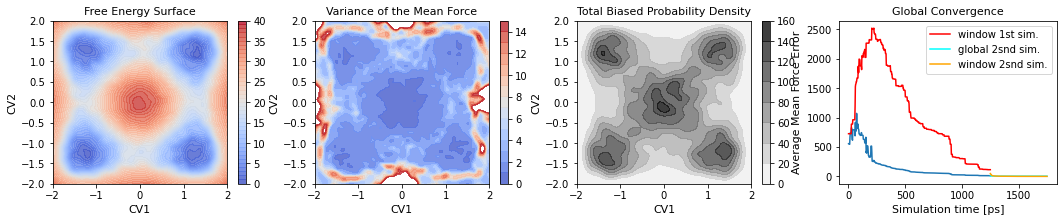

In [60]:
# #Run simulation with Harmonic potential
run_plumed.run_langevin2D(100000, grid_min_x=-3.0, grid_max_x=3.0, grid_min_y=-3.0, grid_max_y=3.0, grid_bin_x=200, grid_bin_y=200, gaus_width_x=0.1, gaus_width_y=0.1, gaus_height=1, biasfactor=5, gaus_pace=100, hp_center_x=0.0, hp_center_y=0.0, hp_kappa_x=50, hp_kappa_y=50, file_extension="BjHP")


#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLS" + "BjHP")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="position" + "BjHP")

#Compute the time-independent mean force
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, ofe_history_window, ofe_history_time, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)), bw = 0.1, kT = 1, log_pace = 5, error_pace = 500, base_terms = Froce_terms_old, window_corners=[-0.5, 0.5, -0.5, 0.5], hp_centre_x=0.0, hp_centre_y=0.0, hp_kappa_x=50, hp_kappa_y=50)

#Patch results
[Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y] = MFI.patch_2D([Froce_terms_old, [Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y]])
ofe_history_time = [element+ofe_history_time_old[-1] for element in ofe_history_time]


#integration on a periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-2, -2)), max_grid=np.array((2, 2)), nbins=np.array((200, 200)))


# Plot Recap
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe, ofe_history_old, ofe_history_time_old, FES_lim=41, ofe_map_lim=16)
plt.plot(ofe_history_time_old, ofe_history_window_old, c="red", label="window 1st sim.")
plt.plot(ofe_history_time, ofe_history, c="cyan", label="global 2snd sim.")
plt.plot(ofe_history_time, ofe_history_window, c="orange", label="window 2snd sim.")
plt.legend()
plt.show()

## C: Invernizzi Potential | 2D non-periodic example

$z = 1.34549*x^4+1.90211*x^3*y+3.92705*x^2*y^2-6.44246*x^2-1.90211*x*y^3+5.58721*x*y+1.33481*x+1.34549*y^4-5.55754*y^2+0.904586*y+18.5598$

#### (0) - Analytical plot

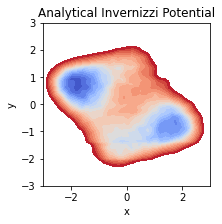

In [15]:
grid = np.linspace(-3, 3, 200); X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598

plt.figure(figsize=(3,3)); plt.contourf(X, Y, FES, levels=range(0, 20, 1), cmap='coolwarm')
plt.xlabel("x"); plt.ylabel("y"); plt.title("Analytical Invernizzi Potential"); plt.show()

#### (1) - Running a metadynamics simulation and analyse with MFI

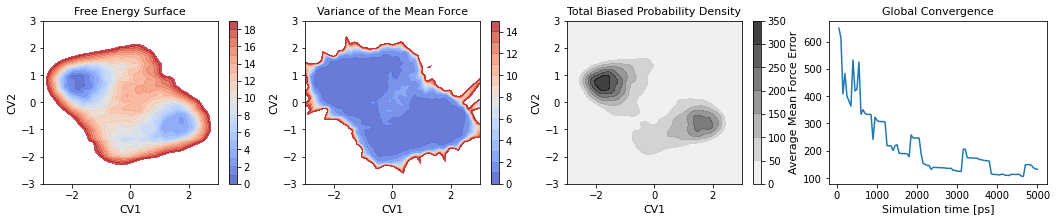

In [17]:
path_data = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/Invernizzi_2D_potential"
os.chdir(path_data)

#Run simulation
run_plumed.run_2D_Invernizzi(simulation_steps=1000000, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=-1, initial_position_y=-1, file_extension="long")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_long")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="positioninve_long")

#COMPUTE Mean force and weight of the simulation
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, ofe_history_time, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.1, kT = 1, log_pace = 5, error_pace = 100)

#integration on a periodic domain
[X, Y, FES] = MFI.intg_2D(Ftot_x, Ftot_y)

#Plot results
MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe, ofe_history, ofe_history_time, FES_lim=20, ofe_map_lim=16)


#### (2) - Running multiple short simulations, patch togehter with MFI, and determine bootstrap error

here we are


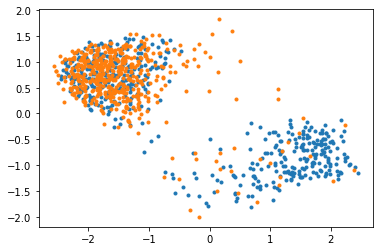

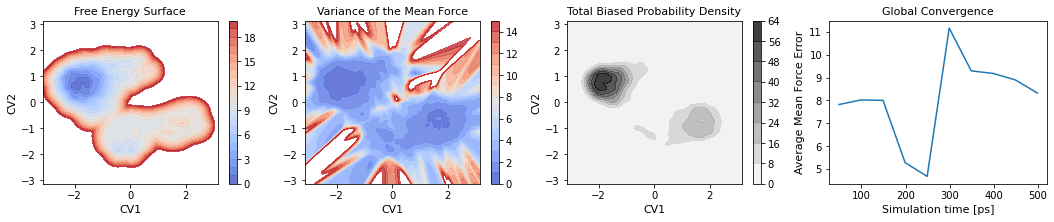

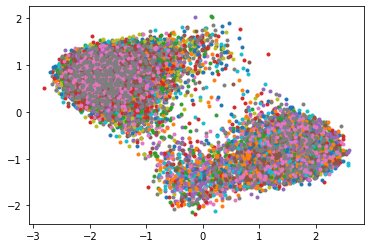

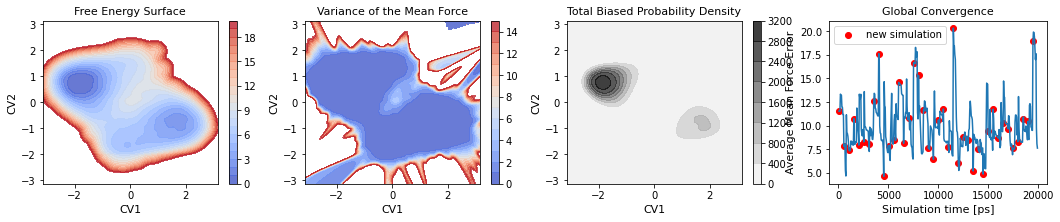

In [2]:
path_data = "/home/antoniu/Desktop/MFI_git/MFI_master/MFI/Invernizzi_2D_potential"
os.chdir(path_data)

forces_all = []

master = []
master_patch = [[np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200))]]
ofe_history_patch = [0]
ofe_history_patch_time = [0]


for simulation in np.arange(0,40):         
    if os.path.exists(path_data + "/forces_inve_" + str(simulation)) == True:
        #Read the HILLS file for traj plot
        HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_"+str(simulation))
        plt.plot(HILLS[:,1],HILLS[:,2],'.')
        
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, ofe_history_time, Ftot_den2, ofv_x, ofv_y] = MFI.load_pkl(path_data + "/forces_inve_" + str(simulation))
    else:
        #Randomize initial position
        [initial_position_x, initial_position_y] = 1.3*(2 * np.random.rand(2) - 1)

        #Run simulation
        run_plumed.run_2D_Invernizzi(simulation_steps=1000000, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=-1, initial_position_y=-1, file_extension=str(simulation))
                                             
        #Read the HILLS file
        HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_"+str(simulation))
        plt.plot(HILLS[:,1],HILLS[:,2],'.')
        
        #Read the Colvar File
        [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_"+str(simulation))
        
        #COMPUTE Mean force and weight of the simulation
        [X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, ofe_history_time, Ftot_den2, ofv_x, ofv_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = 0.12, kT = 1, log_pace = 1, error_pace = 10, nhills=-1)
        
        #save results
        MFI.save_pkl([X, Y, Ftot_den, Ftot_x, Ftot_y, ofe, ofe_history, ofe_history_time, Ftot_den2, ofv_x, ofv_y], path_data + "/forces_inve_" + str(simulation))
        
    if simulation == 1:
        print("here we are")
        [X, Y, FES] = MFI.intg_2D(master_patch[-1][2], master_patch[-1][3])
        MFI.plot_recap_2D(X, Y, FES, Ftot_den, ofe, ofe_history, ofe_history_time, FES_lim=21, ofe_map_lim=16)
        plt.show()

        
         
    forces_all.append([X, Y, Ftot_den, Ftot_x, Ftot_y])
    
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_x, ofv_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save ofe history
    ofe_history_patch += ofe_history
    ofe_history_time_adj = [element+ofe_history_patch_time[-1] for element in ofe_history_time]
    ofe_history_patch_time += ofe_history_time_adj
    
    
#find "standard devaition of mean force" map
[ofe] = MFI.mean_force_variance(master_patch[-1][0], master_patch[-1][1], master_patch[-1][2], master_patch[-1][3], master_patch[-1][4], master_patch[-1][5])

#integration on a periodic domain
[X, Y, FES] = MFI.intg_2D(master_patch[-1][2], master_patch[-1][3])

# Plot Results
#shorten history to remove the first entry
ofe_history_patch = ofe_history_patch[1:]
ofe_history_patch_time = ofe_history_patch_time[1:]
#make "sim_start" list with only the first entry of a simulation
sim_start = [ofe_history_patch_time[i*10] for i in range(40)]
sim_start_error = [ofe_history_patch[i*10] for i in range(40)]

#plot trajectory of all simulations
plt.show()

# Plot Recap
MFI.plot_recap_2D(X, Y, FES, master_patch[-1][0], ofe, ofe_history_patch, ofe_history_patch_time, FES_lim=21, ofe_map_lim=16)
plt.scatter(sim_start, sim_start_error, c="r", label="new simulation")
plt.legend()
plt.show() 

60 : var: 0.17398      sd: nan       FES: var: 20.328      sd: 1.857
120 : var: 0.17276      sd: nan       FES: var: 19.726      sd: 1.844
180 : var: 0.17589      sd: nan       FES: var: 19.144      sd: 1.836
240 : var: 0.17523      sd: nan       FES: var: 19.575      sd: 1.861
300 : var: 0.1744      sd: nan       FES: var: 19.579      sd: 1.855


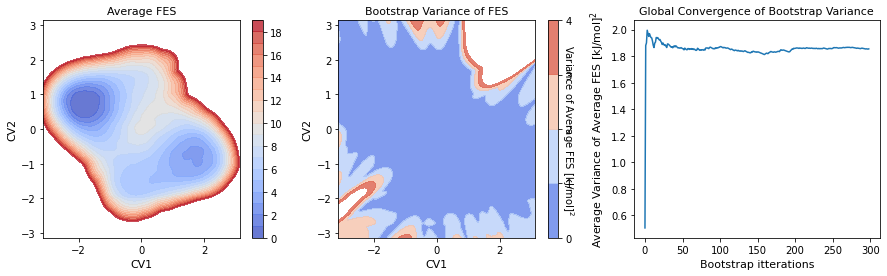

In [5]:
from pyMFI import MFI

#Find bootstrap error of 40 simulations

[FES_avr, var_fes, sd_fes, variance_prog, stdev_prog, var_fes_prog, sd_fes_prog ] = MFI.bootstrap_2D(X, Y, forces_all, 300)

MFI.plot_bootstrap(X, Y, FES_avr, sd_fes, sd_fes_prog, FES_lim=20, ofe_map_lim=5)

#### (3) Some short simulations with HP